In [2]:
import json
from pathlib import Path
from collections import defaultdict
from typing import List, Dict, Any
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
val_file = "/data/user_data/gdhanuka/STAR_dataset/STAR_val.pkl"
with open(val_file, "rb") as f:
    val_data = pickle.load(f)

# make question_id the key for the val_data
val_data = {q['question_id']: q for q in val_data}

In [59]:
import torch
def logits_to_confidence(logits):
    # do softmax
    logits = torch.tensor(logits)
    probs = torch.nn.functional.softmax(logits, dim=0)
    # return list of probabilities
    return probs.numpy().tolist()

def load_jsonl(file_path: str) -> List[Dict[str, Any]]:
    """Load a JSONL file and return a list of dictionaries."""
    with open(file_path, 'r') as file:
        return [json.loads(line) for line in file]

def calculate_metrics(data: List[Dict[str, Any]], convert_to_conf=False) -> Dict[str, Any]:
    """Calculate key metrics from the data."""
    metrics = {
        "total_questions": len(data),
        "correct_predictions": 0,
        "accuracy": 0.0,
        "category_wise_accuracy": defaultdict(lambda: {"correct": 0, "total": 0}),
        "average_inference_time": 0.0,
        "average_confidence": 0.0
    }

    
    total_confidence = 0.0
    total_inference_time = 0.0
    
    for entry in data:
        if convert_to_conf:
            entry["confidence_bkp"] = entry["confidence"]
            entry["confidence"] = logits_to_confidence(entry["confidence"])
        category = entry["category"]
        metrics["category_wise_accuracy"][category]["total"] += 1
        total_inference_time += entry["inference_time"]
        total_confidence += max(entry["confidence"])
        
        if entry["pred_ans_idx"] == entry["true_index"]:
            metrics["correct_predictions"] += 1
            metrics["category_wise_accuracy"][category]["correct"] += 1
    
    metrics["accuracy"] = metrics["correct_predictions"] / metrics["total_questions"] if metrics["total_questions"] > 0 else 0.0
    metrics["average_inference_time"] = total_inference_time / metrics["total_questions"] if metrics["total_questions"] > 0 else 0.0
    metrics["average_confidence"] = total_confidence / metrics["total_questions"] if metrics["total_questions"] > 0 else 0.0
    
    # Calculate category-wise accuracy
    for category, values in metrics["category_wise_accuracy"].items():
        total = values["total"]
        correct = values["correct"]
        values["accuracy"] = correct / total if total > 0 else 0.0
    
    # load information from val_data to get situation and category information
    
    return metrics

def analyze_files(file_paths: List[str], convert_to_conf=False) -> Dict[str, Dict[str, Any]]:
    """Analyze multiple JSONL files and return metrics for each."""
    results = {}
    for file_path in file_paths:
        data = load_jsonl(file_path)
        metrics = calculate_metrics(data, convert_to_conf)
        results[file_path] = metrics
    return results

def display_metrics(metrics: Dict[str, Dict[str, Any]]):
    """Display metrics in a readable format."""
    for file_path, file_metrics in metrics.items():
        print(f"Metrics for file: {file_path}")
        print(f"  Total Questions: {file_metrics['total_questions']}")
        print(f"  Correct Predictions: {file_metrics['correct_predictions']}")
        print(f"  Accuracy: {file_metrics['accuracy']:.2%}")
        print(f"  Average Inference Time: {file_metrics['average_inference_time']:.4f} seconds")
        print(f"  Average Confidence: {file_metrics['average_confidence']:.2%}")
        print("  Category-wise Accuracy:")
        for category, values in file_metrics["category_wise_accuracy"].items():
            print(f"    {category}: {values['accuracy']:.2%} ({values['correct']}/{values['total']})")
        print()

In [60]:
file_paths = ["/home/gdhanuka/STAR_Benchmark/analysis/results/video_llava_4_frames_results.jsonl"]
metrics = analyze_files(file_paths, convert_to_conf=True)
display_metrics(metrics)

Metrics for file: /home/gdhanuka/STAR_Benchmark/analysis/results/video_llava_4_frames_results.jsonl
  Total Questions: 7098
  Correct Predictions: 2726
  Accuracy: 38.41%
  Average Inference Time: 0.3463 seconds
  Average Confidence: 27.79%
  Category-wise Accuracy:
    Interaction: 39.91% (957/2398)
    Sequence: 36.67% (1315/3586)
    Prediction: 41.35% (258/624)
    Feasibility: 40.00% (196/490)



In [51]:
# # Extract confidence probabilities for wrongly answered questions
# wrong_confidences = []

# for file_path, file_metrics in metrics.items():
#     data = load_jsonl(file_path)
#     for entry in data:
#         if entry["pred_ans_idx"] != entry["true_index"]:
#             wrong_confidences.append(max(entry["confidence"]))

# # Plot the confidence probabilities
# plt.figure(figsize=(6, 4))
# sns.histplot(wrong_confidences, bins=20, color='skyblue', edgecolor='black', kde=True)
# plt.title('Confidence Probability for Wrongly Answered Questions')
# plt.xlabel('Confidence')
# plt.ylabel('Frequency')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

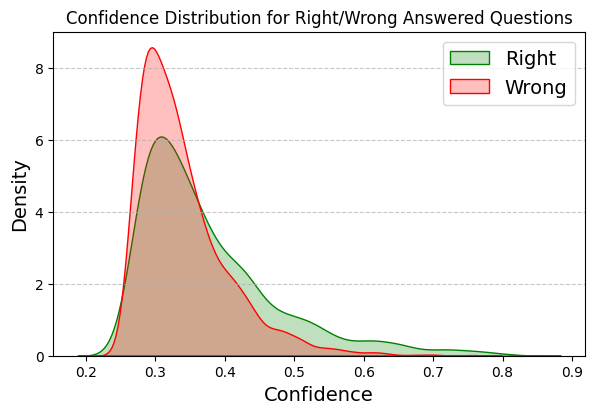

Avg confidence for right answers: 0.3762358233759006
Avg confidence for wrong answers: 0.33945632306731083
Avg confidence for Interaction: 0.3535959494422136
Avg confidence for Sequence: 0.3510217279179164
Avg confidence for Prediction: 0.3533151429146528
Avg confidence for Feasibility: 0.3725841769758536


In [61]:
# Extract confidence probabilities for rightly answered questions
right_confidences = []
wrong_confidences = []

category_confidences = defaultdict(list)

for file_path, file_metrics in metrics.items():
    data = load_jsonl(file_path)
    for entry in data:
        confidences = entry["confidence"]
        if entry["pred_ans_idx"] == entry["true_index"]:
            right_confidences.append(max(confidences))
        else:
            wrong_confidences.append(max(confidences))
        category_confidences[entry["category"]].append(max(confidences))

# Plot the confidence probabilities
plt.figure(figsize=(6, 4))
# sns.histplot(right_confidences, bins=20, color='skyblue', edgecolor='black', kde=True)
sns.kdeplot(right_confidences, color='green', fill=True)
sns.kdeplot(wrong_confidences, color='red', fill=True)
plt.legend(['Right', 'Wrong'], fontsize=14)
plt.title('Confidence Distribution for Right/Wrong Answered Questions')
# plt.xlabel('Confidence')
# plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xlabel('Confidence', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

print("Avg confidence for right answers:", sum(right_confidences) / len(right_confidences))
print("Avg confidence for wrong answers:", sum(wrong_confidences) / len(wrong_confidences))

for category, confidences in category_confidences.items():
    print(f"Avg confidence for {category}:", sum(confidences) / len(confidences))

In [62]:
# # find number of questions that were random guessing, i.e. difference between highest confidence and lowest confidence is less than guess_threshold (0.1)
# guess_threshold = 0.1
# random_guessing_right = 0
# random_guessing_wrong = 0
# for file_path, file_metrics in metrics.items():
#     data = load_jsonl(file_path)
#     for entry in data:
#         if max(entry["confidence"]) - min(entry["confidence"]) < guess_threshold:
#             if entry["pred_ans_idx"] == entry["true_index"]:
#                 random_guessing_right += 1
#             else:
#                 random_guessing_wrong += 1

# print(f"Number of questions that were random guessing: {random_guessing_right+random_guessing_wrong} out of {file_metrics['total_questions']}")
# print(f"Right random guessing: {random_guessing_right}, Wrong random guessing: {random_guessing_wrong}")

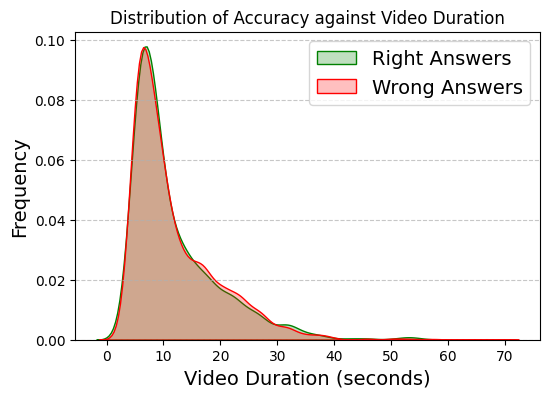

Avg video duration for right answers: 11.905508070432859
Avg video duration for wrong answers: 11.921595379688945


In [52]:
# show the distribution of accuracy against the duration of the video
video_duration_right = []
video_duration_wrong = []

for file_path, file_metrics in metrics.items():
    data = load_jsonl(file_path)
    for entry in data:
        video_duration = val_data[entry["question_id"]]["end"] - val_data[entry["question_id"]]["start"]
        if entry["pred_ans_idx"] == entry["true_index"]:
            video_duration_right.append(video_duration)
        else:
            video_duration_wrong.append(video_duration)

# Plot the distribution
plt.figure(figsize=(6, 4))
# sns.histplot(video_duration_right, bins=20, color='green', edgecolor='black', kde=True, label='Right Answers')
# sns.histplot(video_duration_wrong, bins=20, color='red', edgecolor='black', kde=True, label='Wrong Answers')
sns.kdeplot(video_duration_right, color='green', label='Right Answers', fill=True)
sns.kdeplot(video_duration_wrong, color='red', label='Wrong Answers', fill=True)
plt.title('Distribution of Accuracy against Video Duration')
plt.xlabel('Video Duration (seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Avg video duration for right answers:", sum(video_duration_right) / len(video_duration_right))
print("Avg video duration for wrong answers:", sum(video_duration_wrong) / len(video_duration_wrong))

In [44]:
# # plot inference time distribution
# inference_times = []
# for file_path, file_metrics in metrics.items():
#     data = load_jsonl(file_path)
#     for entry in data:
#         inference_times.append(entry["inference_time"])

# plt.figure(figsize=(10, 6))
# sns.boxplot(inference_times, color='skyblue')
# plt.title('Inference Time Distribution')
# plt.xlabel('Inference Time (seconds)')
# plt.ylabel('Frequency')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

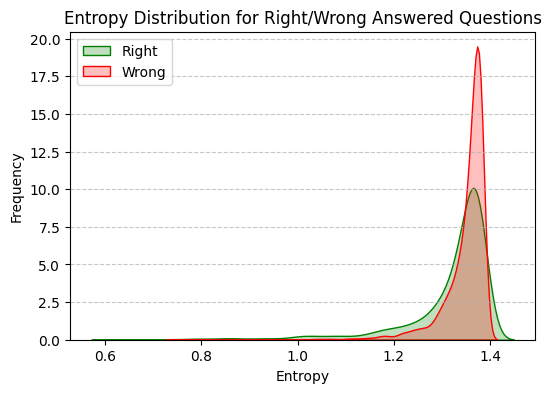

Avg entropy for right answers: 1.3141940444475644
Avg entropy for wrong answers: 1.3477963659362369
Avg entropy (overall) =  1.3348913323523903
Avg entropy for Interaction =  1.3337364127695588
Avg entropy for Sequence =  1.3371876254332036
Avg entropy for Prediction =  1.3351875867627554
Avg entropy for Feasibility =  1.3233609801479074


In [36]:
# compute entropy of the confidence distribution
import numpy as np
from scipy.stats import entropy

correct_entropies = []
wrong_entropies = []
category_entropies = defaultdict(list)
for file_path, file_metrics in metrics.items():
    data = load_jsonl(file_path)
    
    for entry in data:
        if entry["pred_ans_idx"] == entry["true_index"]:
            correct_entropies.append(entropy(entry["confidence"]))
        else:
            wrong_entropies.append(entropy(entry["confidence"]))
        
        category_entropies[entry["category"]].append(entropy(entry["confidence"]))
        # entropies.append(entropy(entry["confidence"]))

plt.figure(figsize=(6, 4))
sns.kdeplot(correct_entropies, color='green', fill=True)
sns.kdeplot(wrong_entropies, color='red', fill=True)
plt.legend(['Right', 'Wrong'])
plt.title('Entropy Distribution for Right/Wrong Answered Questions')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("Avg entropy for right answers:", sum(correct_entropies) / len(correct_entropies))
print("Avg entropy for wrong answers:", sum(wrong_entropies) / len(wrong_entropies))
print("Avg entropy (overall) = ", sum(correct_entropies + wrong_entropies) / len(correct_entropies + wrong_entropies))

for category, entropies in category_entropies.items():
    print(f"Avg entropy for {category} = ", sum(entropies) / len(entropies))

In [47]:
# compute ece score
def ece_score(confidences, predictions, true_labels, num_bins=10):
    """
    Calculate Expected Calibration Error (ECE) score.
    
    Args:
        confidences: array of confidence scores (n,) or (n, num_classes)
        predictions: array of predicted indices (n,)
        true_labels: array of true indices (n,)
        num_bins: number of bins for calibration (default: 10)
    
    Returns:
        float: ECE score
    """
    # Convert inputs to numpy arrays if they aren't already
    confidences = np.array(confidences)
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    # If confidences is 2D (n, num_classes), take max along axis 1
    if len(confidences.shape) > 1:
        confidences = np.max(confidences, axis=1)
    
    # Ensure confidences are between 0 and 1
    confidences = np.clip(confidences, 0, 1)
    
    # Create bin boundaries
    bin_boundaries = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(confidences, bin_boundaries) - 1
    
    # Initialize arrays
    bin_accuracies = np.zeros(num_bins)
    bin_confidences = np.zeros(num_bins)
    bin_counts = np.zeros(num_bins)
    
    # Calculate metrics for each bin
    for i in range(num_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:  # Only compute if there are samples in the bin
            bin_accuracies[i] = np.mean(predictions[mask] == true_labels[mask])
            bin_confidences[i] = np.mean(confidences[mask])
            bin_counts[i] = np.sum(mask)
    
    # Calculate ECE (only for bins with samples)
    nonzero_bins = bin_counts > 0
    if np.sum(nonzero_bins) == 0:
        return 0.0
    
    ece = np.sum((bin_counts[nonzero_bins] / len(confidences)) * 
                 np.abs(bin_accuracies[nonzero_bins] - bin_confidences[nonzero_bins]))
    
    return ece

confidences = []
predictions = []
true_labels = []
for file_path, file_metrics in metrics.items():
    data = load_jsonl(file_path)
    for entry in data:
        confidences.append(entry["confidence"]) 
        predictions.append(entry["pred_ans_idx"])
        true_labels.append(entry["true_index"])

print("ECE score = ", ece_score(np.array(confidences), np.array(predictions), np.array(true_labels)))

ECE score =  0.030470287549593092


In [54]:
def extract_question_metrics(question_data):
    """
    Extract metrics for a single question.

    Args:
        question_data: Dictionary containing question data

    Returns:
        tuple: (question_id, num_unique_objects, num_rel_pairs)
    """
    question_id = question_data["question_id"]

    # Get all situations
    situations = question_data.get("situations", {})

    # Extract unique objects from bbox_labels across all situations
    unique_objects = set()
    total_rel_pairs = 0

    for situation_id, situation_data in situations.items():
        # Add bbox_labels to unique objects set
        bbox_labels = situation_data.get("bbox_labels", [])
        unique_objects.update(bbox_labels)
        
        # Count relationship pairs
        rel_pairs = situation_data.get("rel_pairs", [])
        total_rel_pairs += len(rel_pairs)

    num_unique_objects = len(unique_objects)

    return question_id, num_unique_objects, total_rel_pairs


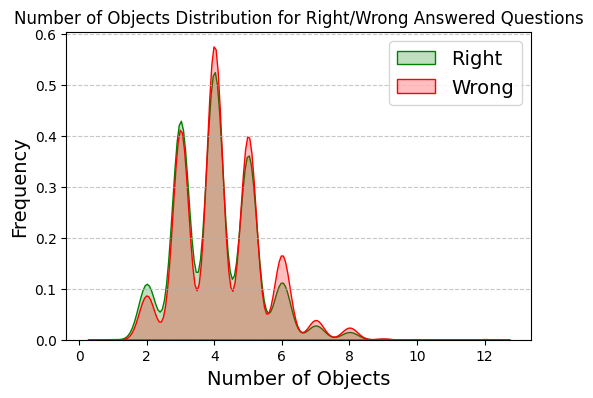

Avg number of objects for right answers: 4.068598679383713
Avg number of objects for wrong answers: 4.223696248856359
Avg number of edges for right answers: 92.60528246515041
Avg number of edges for wrong answers: 92.21203110704484


In [55]:
# compute avg number of objects
num_objects_right = []
num_objects_wrong = []

num_edges_right = []
num_edges_wrong = []

for file_path, file_metrics in metrics.items():
    data = load_jsonl(file_path)
    for entry in data:
        q_id, num_objects, num_rel_pairs = extract_question_metrics(val_data[entry["question_id"]])
        if entry["pred_ans_idx"] == entry["true_index"]:
            num_objects_right.append(num_objects)
            num_edges_right.append(num_rel_pairs)
        else:
            num_objects_wrong.append(num_objects)
            num_edges_wrong.append(num_rel_pairs)

plt.figure(figsize=(6, 4))
sns.kdeplot(num_objects_right, color='green', fill=True)
sns.kdeplot(num_objects_wrong, color='red', fill=True)
plt.legend(['Right', 'Wrong'], fontsize=14)
plt.title('Number of Objects Distribution for Right/Wrong Answered Questions')
plt.xlabel('Number of Objects', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Avg number of objects for right answers:", sum(num_objects_right) / len(num_objects_right))
print("Avg number of objects for wrong answers:", sum(num_objects_wrong) / len(num_objects_wrong))

print("Avg number of edges for right answers:", sum(num_edges_right) / len(num_edges_right))
print("Avg number of edges for wrong answers:", sum(num_edges_wrong) / len(num_edges_wrong))
